# SVM Classifier for non-linearly separable data

In [ ]:
# Import packages to visualize the classifer
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings

In [ ]:
# Make all figures tiny so as to not get lost
matplotlib.rcParams['figure.figsize'] = (5,3)

In [ ]:
# Import other libraries
import numpy as np

## Utils

In this notebook, we give your the following function to plot the decision regions of your classifier

In [ ]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map up for up to 5 classes
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    marker='x', label=cl)

    # Plot test samples if they exist
    if not test_idx is None:
        X_test, y_test = X[test_idx, :], y[test_idx]
        for idx, cl in enumerate(np.unique(y_test)):
            plt.scatter(x=X_test[y_test == cl, 0], y=X_test[y_test == cl, 1],
                        alpha=1, color=cmap(idx),
                        linewidths=1, marker='o', s=55, label=f'test {cl}')
    plt.legend()

## XOR dataset

We will create a 2D dataset that is non-linearly separable, using [logical XOR gates](https://en.wikipedia.org/wiki/XOR_gate)

Try to understand how this work by playing with `np.logical_xor` in the cells below:

In [ ]:
print(np.logical_xor(True, True))
print(np.logical_xor(True, False))
print(np.logical_xor(False, False))

In [ ]:
np.logical_xor([True, True, False, False], [True, False, True, False])

Let's now create a own synthetic 2D dataset where y=1 if and only if (X1>0 **xor** X2>0)

Make sure to understand the logic coded for you below

In [ ]:
# Number of datapoints
n = 500
noise = 0.2

In [ ]:
# Build our X randomly from gaussian distributions
np.random.seed(0)
X = np.random.randn(n, 2)
plt.scatter(X[:,0], X[:,1]);

In [ ]:
# Build our y wisely
epsilon = noise * np.random.randn(n, )
x1 = X[:, 0]
x2 = X[:, 1]

y_bool = np.logical_xor(
    x1 > epsilon, 
    x2 > epsilon
    )
y = np.where(y_bool, 1,0)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### Linear SVM

Find a vector $w$ (and intercept b) such that

$$
\hat{y} = 0 \text{ if}\ w^Tx + b < 0 \\
\hat{y} = 1 \text{ if}\ w^Tx + b ≥ 0
$$

In this formula, we have to evaluate the scalar product (i.e "cosine distance") between two points: $ K(x_1,x_2) = {x_1}^Tx_2$ is called the linear kernel.

When applied to the vector $w$ defining the hyperplane margin, $K(w,x)$ is the perpendicular distance to the decision boudary hyperplane 👇


<img src="https://github.com/lewagon/data-images/blob/master/ML/svm_kernel.jpg?raw=true" width=500 >

❓ Fit a **linear** SVC classifier on the whole dataset with the value C = 1. Think of `C` as the "cost associated with the wrong classification".  A strict margin classifier has `C` = $+ \infty$

❓ Visualize the decision boundaries using the `plot_decision_regions` utils coded for you above. Before you plot it:

- What do you think the delimiter margin will look like?
- Do you think the value of `C` has any importance in this case?

☝️ A Linear SVM will never be able to classify correctly the data, whathever the cost applied to wrongly classified datapoints. We are _structurally_ trying to fit the wrong type of model to the dataset. 

❓ Do you think a Logistic Regression would perform better? Feel free to try.

### Polynomial Kernels

A polynomial kernel of degree 2 is equivalent to creating the new quadratic features as below 

$K(x_1,x_2) = (x_1^Tx_2 + c )^2 \rightarrow \phi(x) = \begin{bmatrix} x_1^2 \\ x_1 x_2 \\ x_2 x_1 \\ x_2^2 \\  \sqrt{2c} \ x_1 \\ \sqrt{2c} \ x_2\end{bmatrix}$



❓ Intuitively speaking, what's the minimum number of kernel "degrees" do you think we need to best fit our XOR dataset? 

Try it below using large C values to keep fitting "maximum maring classifiers"

<details>
    <summary>☝️ Answer</summary>

Degree 2 should be enough because the XOR can be computed from the product feature $x1x2$: class = 1 if product is negatif, class = 0 esle! 
</details>


## Make Moon dataset

Let's now try with a harder dataset to classifiy!

In [ ]:
n=200

In [ ]:
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=n, noise=0.25, random_state=0)
plt.scatter(X[:,0], X[:,1], c=y)

❓ Can you fit a polynomial kernel to such data? Try it out below! (`pip install ipywidget` if you haven't done it already)

In [ ]:
from ipywidgets import interact

@interact(C=[1, 10, 1000, 10000, 100000], degree=3)
def svc(C, degree):
    svm = SVC(kernel='poly', C=C, degree=degree)
    svm.fit(X, y)
    plot_decision_regions(X, y, classifier=svm)

### RBF (gaussian) Kernel

Here comes the RBF Kernel! 
Pretty much the go-to kernel for SVM (and default one in sklearn).  
It proves very robust to variety of problems, but requires gridsearching its hyper-parameter $\lambda$

$K(x_1,x_2) = \exp[ \left( - \gamma ||x_1-x_2||^2\right)$

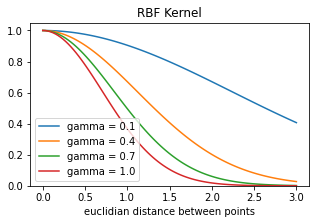

In [182]:
x = np.linspace(0,3,100)
for gamma in np.linspace(0.1, 1, 4):
    plt.plot(x,np.exp(-gamma*x**2), label=f'gamma = {gamma}');
plt.ylim(0,); plt.title('RBF Kernel'); plt.xlabel('euclidian distance between points'); plt.legend()

- The larger the euclidian distance between two points $||x_1-x_2||^2$, the closer the kernel function is to zero. This means that two points far away are more likely to be different.

- $\gamma$ reduces each instance’s range of influence on the others (myopia). If your model overfits, increase it, it should smooth out irregularities and reduce variance

- $C$ still controls the "hardness" of the margin. Stronger values will make your model overfits.

❓ Test and visualize an SVM classifier with an RBF kernel.  
Start with a model with very low variance (ex: $\gamma=0.05$ and $C=0.1$), and coarse-grain increase gamma until you overfit

❓ Now, lets start back from your best estimated value of gamma, and increase `C` until you overfit


☝️ Feel free to create your own interactive plot with @interact

### Sigmoid kernel

$K(x_1,x_2) = tanh(\gamma x_1^T x_2 +r)$

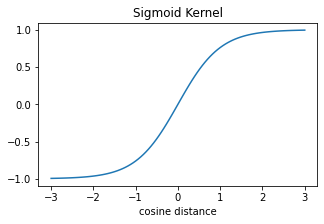

In [186]:
# The "tangent hyperbolic" function ressembles sigmoid but can take negative values
x = np.linspace(-3,3,100)
plt.plot(x, np.tanh(x))
plt.xlabel('cosine distance'); plt.title('Sigmoid Kernel');

☝️ The Sigmoid kernel compresses the cosine distance used in the linear kernel into a [-$\gamma$,+$\gamma$] interval. A similar kernel is used in Neural Network. 

In [ ]:
@interact(C=[0.1, 1, 10, 100, 1000, 10000], gamma = [0.001, 0.01, 0.1, 1, 10])
def svc(C=1000, gamma=0.1):
    svm = SVC(kernel='sigmoid', gamma=gamma, C=C)
    svm.fit(X, y)
    plot_decision_regions(X, y, classifier=svm)

☝️  Not easy to make it work visually, right? Besides, another hyper-parameter $r$ in the Kernel formula has not been tested (`coef0` in sklearn)

Time for a grid-search!

### GridSearch the best `sigmoid` kernel ?

❓ We need to gridsearch to find the best hyperparams for the `sigmoid` kernel
- Using your visual intuitions above, define plausible range of values for `gamma`, `C` and `coef0` to try out
- Gridsearch them using `RandomizedSearchCV`
- Plot your best model and cross-validated its score

Remeber to coarse grain your search first, and refine later

### What about the kNN Classifier?

Such problem could also well fit a kNN classifier. Try to find visually the best `k` and visually compare its behavior to the SVM.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
@interact(k=5)
def knn(k):
    pass

## Generalization

Suppose your model is in production, receive a new test dataset that has never been seen before

In [ ]:
# We generate for you a test set
n_test = 100
X_test, y_test = make_moons(n_samples=n, noise=0.2, random_state=1)

X_full = np.vstack((X, X_test))
y_full = np.append(y, values = y_test)
test_idx = np.arange(n,n+n_test)

❓ Plot the decision regions for what you think is your best svm model already trained before!

🔥 You only have **one** trial! Too late to change your hyper-parameters now that you've seen the test set :))))

Includes the test indexes to `plot_decision_regions` and count how many misclassified test samples you get!

❓ print your `classification_report` to finish

🏁 Congratulation! Dont forget to **commit** and **push** your notebook